# 注意力汇聚：Nadaraye-Watson核回归

In [61]:
import torch
from torch import nn
from d2l import torch as d2l

## 1. 生成数据集
通过如下非线性函数生成人工数据集，噪声项为$\epsilon$
$$
y_i = 2 \sin(x_i) + x_i^{0.8} + \epsilon
$$
$\epsilon$服从均值为0，标准差为0.5的正态分布。这里生成了50个训练样本和50个测试样本。为了更好可视化之后的注意力模型，对训练样本进行排序。

In [62]:
n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, )) # 训练样本输出
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test) # 测试样本的真实输出
n_test = len(x_test)
n_test



50

In [63]:
'''绘制所有训练样本
不带噪声项的真实数据生成函数f（标记为truth）
学习到的预测函数（标记为pred）
'''
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

## 2. 平均汇聚
$$f(x)=\frac{1}{n} \sum_{i=1}^{n} y_i$$

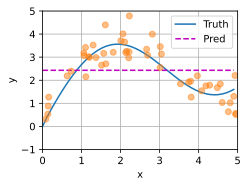

In [64]:
'''真实函数f("Truth")个预测函数("pred")相差很大'''
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 3. 非参数注意力汇聚
平均汇聚忽略了输入$x_i$。Nadaraya和Watson提出了一个更好的想法，根据输入位置对输出$y_i$进行加权。称为Nadaraya-Watson核回归
$$
f(x) = \sum_{i=1}^{n}{\frac{K(x-x_i)}{\sum_{j=1}^{n}K(x-x_j)}y_i}
$$
$K$是核（kernel）。对上面的公式重写，成为一个更加通用的注意力汇聚（attention pooling）公式：
$$
f(x) = \sum_{i=1}^{n}{\alpha (x, x_i)y_i}
$$
$x$是查询，$(x, x_i)$是键值对，注意力汇聚是$y_i$的加权平均。查询$x$和键$x_i$之间的关系建模为注意力权重(attention weight)$\alpha (x, x_i)$，这个权重分配个一个对应值的$y_i$。对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布，非负，总和为1。
$$
K(u) = \frac{1}{\sqrt{2 \pi}} \exp(-\frac{u^2}{2})
$$
将核函数公式带入注意力权重公式中，可以得到：
$$
f(x) = \sum_{i=1}^{n} \alpha(x, x_i) y_i \\
= \sum_{i=1}^{n} \frac{\exp \left( -\frac{1}{2} (x - x_i)^2 \right)}{\sum_{j=1}^{n} \exp \left( -\frac{1}{2} (x - x_j)^2 \right)} y_i \\
= \sum_{i=1}^{n} \text{softmax} \left( -\frac{1}{2} (x - x_i)^2 \right) y_i.
$$
可以观察到，如果一个键$x_i$越接近查询到的$x$，分配给这个键对应值$y_i$的注意力权重就会越大，得到更多注意力。

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。 因此， (10.2.6)是 非参数的注意力汇聚（nonparametric attention pooling）模型。 接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。 从绘制的结果会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。

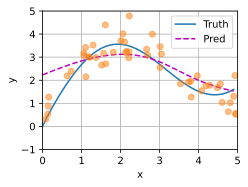

In [65]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在来观察注意力的权重。 这里测试数据的输入相当于查询，而训练数据的输入相当于键。 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高。

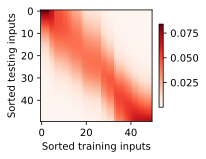

In [66]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

## 4. 带参数化注意力汇聚
将可学习的参数集成到注意力汇聚中，在查询$x$和键$x_i$之间的距离乘以可学习参数$w$：
$$
f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i \\
= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2} ((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2} ((x - x_j)w)^2\right)} y_i \\
= \sum_{i=1}^n \text{softmax}\left(-\frac{1}{2} ((x - x_i)w)^2\right) y_i.
$$

后续部分将对使用带参数的注意力汇聚进行训练学习

## 5. 批量矩阵乘法
假定两个张量的形状为$(n, a, b)$和$(n, b, c)$，批量矩阵乘法输出形状为$(n, a, c)$

torch.bmm是batch matrix multiplication

In [67]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [68]:
'''使用小批量矩阵乘法计算小批量数据中加权平均值
'''
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)) # 插入维度
# 变为(2, 1, 10) 和 (2, 10, 1)

tensor([[[ 4.5000]],

        [[14.5000]]])

## 6. 定义模型
定义Nadaraya-Watson核回归的带参数版本

In [69]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

## 7. 训练
训练集变换为键和值用于训练注意力模型。在带参数的注意力汇聚模型中， 任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算， 从而得到其对应的预测输出。

In [70]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

训练带参数的注意力汇聚模型时，使用平方损失函数和随机梯度下降。

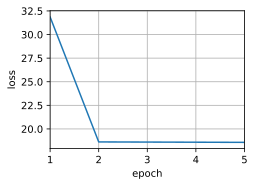

In [71]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

如下所示，训练完带参数的注意力汇聚模型后可以发现： 在尝试拟合带噪声的训练数据时， 预测结果绘制的线不如之前非参数模型的平滑。

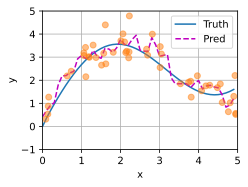

In [72]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

为什么新的模型更不平滑了呢？ 下面看一下输出结果的绘制图： 与非参数的注意力汇聚模型相比， 带参数的模型加入可学习的参数后， 曲线在注意力权重较大的区域变得更不平滑。

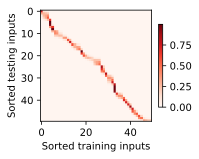

In [73]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')